In [2]:
import torch
from diffusers import StableDiffusionPipeline
from tqdm import tqdm

Load the Stable Diffusion model

In [3]:
# !pip install --upgrade diffusers transformers accelerate safetensors
# !pip install huggingface_hub
# from huggingface_hub import notebook_login
# notebook_login()

In [4]:
# pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", token=...)
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")
pipe = pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Get text embeddings

In [5]:
max_length = 50

tokenizer = pipe.tokenizer
text_encoder = pipe.text_encoder
vae = pipe.vae

prompt = "A futuristic car"

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

diffusion_model = pipe.unet
timesteps = 10
alpha_t = 0.5
criterion = nn.MSELoss()
optimizer = optim.Adam(diffusion_model.parameters(), lr=1e-4)

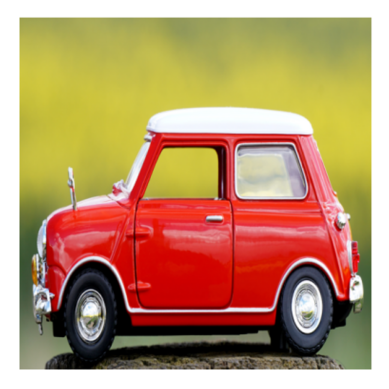

In [9]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms

image_path = "Voiture_Genia.png"
image = Image.open(image_path).convert("RGB")
image = image.resize((512, 512))

plt.imshow(image)
plt.axis("off")
plt.show()

image = transforms.ToTensor()(image).unsqueeze(0)  # Add batch dimension
image = image.to(diffusion_model.device)

In [ ]:
def optimize_embeddings(input_image, target_text, num_steps=5):
    tokens = tokenizer(target_text, padding="max_length", truncation=True, max_length=max_length, return_tensors="pt")

    tokens = tokens.to(diffusion_model.device)

    with torch.no_grad():
        e_tgt = text_encoder(tokens["input_ids"]).last_hidden_state

    e_tgt = e_tgt.requires_grad_(True)

    # freeze models parameters
    text_encoder.eval()
    diffusion_model.eval()
    vae.eval()

    with torch.no_grad():
        latents = vae.encode(input_image).latent_dist.sample() # diffusion model doesn't directly take an RGB image as input

    old_latents = latents.detach().clone()

    for _ in tqdm(range(num_steps)):
        noise = torch.randn_like(old_latents)
        sqrt_alpha = np.sqrt(alpha_t)
        latents = sqrt_alpha * old_latents + (1-sqrt_alpha) * noise

        noise_pred = diffusion_model(latents, timestep=timesteps, encoder_hidden_states=e_tgt).sample

        # update embeddings
        optimizer.zero_grad()
        loss = criterion(noise_pred, noise)
        loss.backward()
        optimizer.step()

        old_latents = latents.detach().clone()

    # get the final embedding after update
    return e_tgt.detach()

e_tgt = optimize_embeddings(image, prompt)
print(e_tgt.shape)

  0%|          | 0/5 [00:00<?, ?it/s]